## HR Analytics Ensemble Model

#### Set source path to import code

In [75]:
%pwd

'E:\\Conway\\HR-Analytics\\source'

In [76]:
local_testing = True
if local_testing:
    source_path = 'E:\Conway\HR-Analytics\source'
else:
    source_path = 'E:\HR-Analytics\source'
source_path

'E:\\Conway\\HR-Analytics\\source'

In [77]:
import os
os.chdir(source_path)
%pwd

'E:\\Conway\\HR-Analytics\\source'

In [78]:
ls

 Volume in drive E is DATA
 Volume Serial Number is AEFF-63BE

 Directory of E:\Conway\HR-Analytics\source

08/28/2019  01:34 PM    <DIR>          .
08/28/2019  01:34 PM    <DIR>          ..
08/28/2019  01:04 PM                 2 __init__.py
08/29/2019  04:17 PM    <DIR>          __pycache__
08/28/2019  01:04 PM            16,924 base_table.py
08/28/2019  01:04 PM            26,727 calendrical.py
08/28/2019  01:04 PM             3,963 config_jnap.yml
08/28/2019  01:04 PM            13,253 config_shap.yml
08/28/2019  01:04 PM             6,561 config_tac.yml
08/28/2019  01:04 PM               498 config_wap.yml
08/28/2019  01:04 PM             6,122 config_wtap.yml
08/28/2019  01:04 PM             6,306 database.py
08/28/2019  01:04 PM             9,710 main.py
08/28/2019  02:49 PM            42,029 model.py
08/28/2019  01:04 PM             3,072 pipeline.yml
08/28/2019  01:33 PM             3,220 pipeline_jnap.py
08/28/2019  01:54 PM             3,220 pipeline_shap.py
08/28/2019  01:54

#### Jupyter Magic

In [79]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
%matplotlib inline

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


#### Imports

In [81]:
import alphapy
import datetime
import logging
import itertools
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.imputation.mice as smi
import xgboost as xgb

In [82]:
# Internal Python Packages
from calendrical import get_nth_kday_of_month
from database import connect_greenplum
from database import create_frame_from_pg
from database import write_frame_to_pg
from database import create_sqlalchemy_engine
from main import get_pipeline_config
from main import get_plant_config
from model import create_ensemble
from model import create_prediction_frame
from model import exog_funcs
from model import generate_future_frame
from model import get_crew_dates
from model import make_plant_predictions
from model import make_sarimax_predictions
from model import make_share_predictions
from model import predict_arima
from model import sequence_frame
from model import set_day
from model import set_day_of_week
from model import set_day_of_year
from model import set_month
from model import set_quarter
from model import set_week
from model import store_predictions
from pipeline_jnap import jnap_crew_map

In [10]:
pd.options.mode.chained_assignment = None

In [11]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test


#### SHAP Initialization

In [12]:
use_shap = True

In [13]:
# load JS visualization code to notebook
if use_shap:
    shap.initjs()

#### Get specifications

In [14]:
pipeline_specs = get_pipeline_config(source_path)
pipeline_specs

INFO:main:Pipeline Configuration
INFO:main:PIPELINE CONFIGURATION:
INFO:main:datalake:schema          = lab_datasci
INFO:main:datalake:host            = shbdmdwp001.servers.chrysler.com
INFO:main:datalake:port            = 5432
INFO:main:datalake:user            = datasci
INFO:main:datalake:password        = datasci_01
INFO:main:datalake:database        = odshawq
INFO:main:jdbc:driver              = com.ibm.db2.jcc.DB2Driver
INFO:main:jdbc:server              = jdbc:db2://SRVR1874.dbms.chrysler.com:18740/AUCERPTP
INFO:main:jdbc:user                = datasci
INFO:main:jdbc:password            = datasci_01
INFO:main:jdbc:jar_file            = c:/installed/sqllib/java/db2jcc4.jar
INFO:main:holidays:calendar_us     = ['2016-01-01', '2016-01-18', '2016-03-25', '2016-03-28', '2016-05-30', '2016-07-04', '2016-09-05', '2016-11-08', '2016-11-11', '2016-11-24', '2016-11-25', '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30', '2017-01-02', '2017-01-22', '2017-04-14', '2017-04-1

{'datalake': {'schema': 'lab_datasci',
  'host': 'shbdmdwp001.servers.chrysler.com',
  'port': 5432,
  'user': 'datasci',
  'password': 'datasci_01',
  'database': 'odshawq'},
 'jdbc': {'driver': 'com.ibm.db2.jcc.DB2Driver',
  'server': 'jdbc:db2://SRVR1874.dbms.chrysler.com:18740/AUCERPTP',
  'user': 'datasci',
  'password': 'datasci_01',
  'jar_file': 'c:/installed/sqllib/java/db2jcc4.jar'},
 'holidays': {'calendar_us': ['2016-01-01',
   '2016-01-18',
   '2016-03-25',
   '2016-03-28',
   '2016-05-30',
   '2016-07-04',
   '2016-09-05',
   '2016-11-08',
   '2016-11-11',
   '2016-11-24',
   '2016-11-25',
   '2016-12-26',
   '2016-12-27',
   '2016-12-28',
   '2016-12-29',
   '2016-12-30',
   '2017-01-02',
   '2017-01-22',
   '2017-04-14',
   '2017-04-17',
   '2017-05-29',
   '2017-07-04',
   '2017-09-04',
   '2017-11-10',
   '2017-11-22',
   '2017-11-23',
   '2017-12-25',
   '2017-12-26',
   '2017-12-29',
   '2017-12-30',
   '2017-12-31',
   '2018-01-01',
   '2018-01-15',
   '2018-03-30'

In [15]:
plant_id = 'jnap'
plant_id

'jnap'

In [16]:
pipeline_specs['plant_id'] = plant_id
pipeline_specs['project_directory'] = source_path
pipeline_specs

{'datalake': {'schema': 'lab_datasci',
  'host': 'shbdmdwp001.servers.chrysler.com',
  'port': 5432,
  'user': 'datasci',
  'password': 'datasci_01',
  'database': 'odshawq'},
 'jdbc': {'driver': 'com.ibm.db2.jcc.DB2Driver',
  'server': 'jdbc:db2://SRVR1874.dbms.chrysler.com:18740/AUCERPTP',
  'user': 'datasci',
  'password': 'datasci_01',
  'jar_file': 'c:/installed/sqllib/java/db2jcc4.jar'},
 'holidays': {'calendar_us': ['2016-01-01',
   '2016-01-18',
   '2016-03-25',
   '2016-03-28',
   '2016-05-30',
   '2016-07-04',
   '2016-09-05',
   '2016-11-08',
   '2016-11-11',
   '2016-11-24',
   '2016-11-25',
   '2016-12-26',
   '2016-12-27',
   '2016-12-28',
   '2016-12-29',
   '2016-12-30',
   '2017-01-02',
   '2017-01-22',
   '2017-04-14',
   '2017-04-17',
   '2017-05-29',
   '2017-07-04',
   '2017-09-04',
   '2017-11-10',
   '2017-11-22',
   '2017-11-23',
   '2017-12-25',
   '2017-12-26',
   '2017-12-29',
   '2017-12-30',
   '2017-12-31',
   '2018-01-01',
   '2018-01-15',
   '2018-03-30'

In [17]:
prediction_date = '2019-09-01'
prediction_date

'2019-09-01'

In [18]:
plant_specs = get_plant_config(pipeline_specs)
plant_specs

INFO:main:Plant Configuration
INFO:main:PLANT CONFIGURATION:
INFO:main:plant:code             = 4012
INFO:main:plant:shift_days       = 4
INFO:main:plant:shift_hours      = 10
INFO:main:plant:absence_codes    = ['BERC', 'BERE', 'BERU', 'BERX', 'CARE', 'CARU', 'FMLA', 'FMLD', 'FMLU', 'HOMD', 'ILFE', 'ILFU', 'IPBE', 'IPME', 'IPNU', 'IPSE', 'JURE', 'MISE', 'MISU', 'PERU', 'PPAA', 'PPAU', 'TRAG', 'WTRU']
INFO:main:plant:exclude_dates    = [['2018-08-25', '2018-08-31'], ['2019-01-02', '2019-01-05'], ['2020-08-10', '2020-08-14']]
INFO:main:base_table:start_date  = 2017-01-01
INFO:main:base_table:end_date    = None
INFO:main:base_table:write_table = 1
INFO:main:model:models           = ['sarimax']
INFO:main:model:target           = absences_unplanned
INFO:main:model:levels           = ['crew', 'production_line']
INFO:main:model:crews            = ['A', 'B', 'C']
INFO:main:model:departments      = {'Material': '3300', 'Body Shop': '9110', 'Paint Shop': '9130', 'Trim': '9150', 'Chassis': '9170'

{'plant': {'code': 4012,
  'shift_days': 4,
  'shift_hours': 10,
  'absence_codes': ['BERC',
   'BERE',
   'BERU',
   'BERX',
   'CARE',
   'CARU',
   'FMLA',
   'FMLD',
   'FMLU',
   'HOMD',
   'ILFE',
   'ILFU',
   'IPBE',
   'IPME',
   'IPNU',
   'IPSE',
   'JURE',
   'MISE',
   'MISU',
   'PERU',
   'PPAA',
   'PPAU',
   'TRAG',
   'WTRU'],
  'exclude_dates': [['2018-08-25', '2018-08-31'],
   ['2019-01-02', '2019-01-05'],
   ['2020-08-10', '2020-08-14']]},
 'base_table': {'start_date': datetime.date(2017, 1, 1),
  'end_date': None,
  'write_table': True},
 'model': {'models': ['sarimax'],
  'target': 'absences_unplanned',
  'npreds': 4,
  'p_arima': 1,
  'd_arima': 0,
  'q_arima': 0,
  'features': ['actual_hours',
   'lost_hours',
   'absences_unplanned_rolling_median_12',
   'absences_unplanned_rolling_median_20',
   'quarter',
   'month',
   'week',
   'day',
   'day_of_week',
   'day_of_year'],
  'top_features': 5,
  'band_pct': 0.3,
  'levels': ['crew', 'production_line'],
  'c

In [19]:
plant_specs['prediction_date'] = prediction_date

#### Experiment with the Different Models

In [20]:
plant_specs['model']['models']

['sarimax']

In [21]:
plant_specs['model']['models'] = ['sarimax']

In [ ]:
plant_specs['model']['models'] = ['share']

In [ ]:
plant_specs['model']['models'] = ['sarimax', 'share']

In [22]:
plant_specs['model']['models']

['sarimax']

#### Model Table

In [83]:
pwd

'E:\\Conway\\HR-Analytics\\source'

In [84]:
data_path = 'E:/HR-Analytics/data/'

In [85]:
table_date = '20190908'
table_date

'20190908'

In [86]:
table_name = '_'.join(['abs', plant_id, 'base', table_date, 'tbl'])
table_name

'abs_jnap_base_20190908_tbl'

In [87]:
file_name = '.'.join([table_name, 'csv'])
file_path = '/'.join([data_path, file_name])
df_base = pd.read_csv(file_path, low_memory=False)

In [88]:
df_base['workdate'].max()

'2019-09-03'

In [97]:
df_base[df_base['workdate'] == '2019-08-29']['abs_code'].value_counts()

        5457
VACF      63
FMLA      58
HOMC      46
UBUS      41
MISU      36
POOL      30
HOMR      22
PERE      10
PERU       5
HOMF       4
BERE       2
??LE       2
IPBE       2
DISC       1
HOMU       1
Name: abs_code, dtype: int64

In [89]:
df_base.shape

(5671092, 32)

In [90]:
df_base.columns

Index(['cid', 'workdate', 'ch_flexwrk_code', 'zip', 'lost_hrs', 'abs_code',
       'c_typ', 'ch_corploc', 'ch_dept', 'ch_supv_grp', 'shift', 'ch_actl_hrs',
       'ch_paa_hrs', 'holiday_hrs', 'birthdate', 'job_classification',
       'empl_tmp', 'empl_part_time', 'straight_hrs_by_payweek',
       'time_half_hrs_by_payweek', 'double_time_hrs_by_payweek',
       'shift_premium_by_payweek', 'eg_by_payweek', 'hrlypayrate',
       'offrole_hours_for_period', 'offrole_reason_code_for_period', 'team',
       'age', 'tenure', 'is_work_day', 'crew', 'production_line'],
      dtype='object')

In [91]:
table_name = '_'.join(['abs', plant_id, 'model_seq', table_date, 'tbl'])
table_name

'abs_jnap_model_seq_20190908_tbl'

In [92]:
file_name = '.'.join([table_name, 'csv'])
file_path = '/'.join([data_path, file_name])
df_model = pd.read_csv(file_path, low_memory=False)

In [93]:
df_model['workdate'].max()

'2019-08-29'

In [94]:
df_model.shape

(26532, 48)

In [35]:
df_model.columns

Index(['workdate', 'crew', 'production_line', 'group_total_cid', 'lost_hours',
       'actual_hours', 'paa_hours', 'absences_unplanned', 'absences_late',
       'absences_noshow', 'absences_any', 'mean_absence_pct',
       'mean_experience', 'absences_planned', 'home_canvasses',
       'absences_fmla', 'peia_count', 'tpt_count', 'streak_1', 'streak_2',
       'streak_3', 'streak_4_plus', 'cluster', 'group_total', 'tpt_unplanned',
       'tpt_extra', 'absences_unplanned_rolling_sum_5',
       'absences_unplanned_rolling_median_5',
       'absences_unplanned_rolling_sum_12',
       'absences_unplanned_rolling_median_12',
       'absences_unplanned_rolling_sum_20',
       'absences_unplanned_rolling_median_20', 'actual_hours_rolling_mean_20',
       'actual_hours_rolling_median_20', 'lost_hours_rolling_mean_20',
       'lost_hours_rolling_median_20', 'kp_residual_5', 'kp_residual_12',
       'kp_residual_20', 'year', 'quarter', 'month', 'week', 'day',
       'day_of_week', 'day_of_year', 

In [36]:
for f in df_model.columns:
    print(f, df_model[f].dtype)

workdate object
crew object
production_line object
group_total_cid float64
lost_hours float64
actual_hours float64
paa_hours float64
absences_unplanned int64
absences_late float64
absences_noshow float64
absences_any float64
mean_absence_pct float64
mean_experience float64
absences_planned float64
home_canvasses float64
absences_fmla float64
peia_count float64
tpt_count float64
streak_1 float64
streak_2 float64
streak_3 float64
streak_4_plus float64
cluster float64
group_total float64
tpt_unplanned float64
tpt_extra float64
absences_unplanned_rolling_sum_5 float64
absences_unplanned_rolling_median_5 float64
absences_unplanned_rolling_sum_12 float64
absences_unplanned_rolling_median_12 float64
absences_unplanned_rolling_sum_20 float64
absences_unplanned_rolling_median_20 float64
actual_hours_rolling_mean_20 float64
actual_hours_rolling_median_20 float64
lost_hours_rolling_mean_20 float64
lost_hours_rolling_median_20 float64
kp_residual_5 float64
kp_residual_12 float64
kp_residual_20 flo

In [37]:
df_model['production_line'].value_counts()

Body Shop        1562
Paint Shop       1562
                 1561
Quality 1        1560
Material         1560
Rolls            1557
Chassis 3        1554
Final 1          1553
Chassis 1 & 2    1551
Trim 1           1550
Sunroof Deck     1549
Door Line        1548
Final 2          1548
Chassis 4        1547
Engine Line      1545
Quality 2        1545
Trim 2           1544
Name: production_line, dtype: int64

In [ ]:
df_model[df_model['production_line'] == ' ']

In [ ]:
test_date = '2019-05-28'
test_crew = 'A'
test_pline = 'Trim 1'
df_model.query('workdate == @test_date').query('crew == @test_crew').query('production_line == @test_pline')

In [65]:
minimum_absences = 20
df_crew = df_model.groupby(['workdate', 'crew'])['absences_unplanned'].sum().reset_index()
df_crew = df_crew[df_crew['absences_unplanned'] >= minimum_absences]

In [66]:
df_crew[df_crew['crew'] == 'A']

,workdate,crew,absences_unplanned
0,2017-01-03,A,77
2,2017-01-04,A,62
4,2017-01-05,A,69
10,2017-01-09,A,95
12,2017-01-10,A,268
14,2017-01-11,A,83
16,2017-01-12,A,78
24,2017-01-17,A,91
26,2017-01-18,A,81
28,2017-01-19,A,67


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


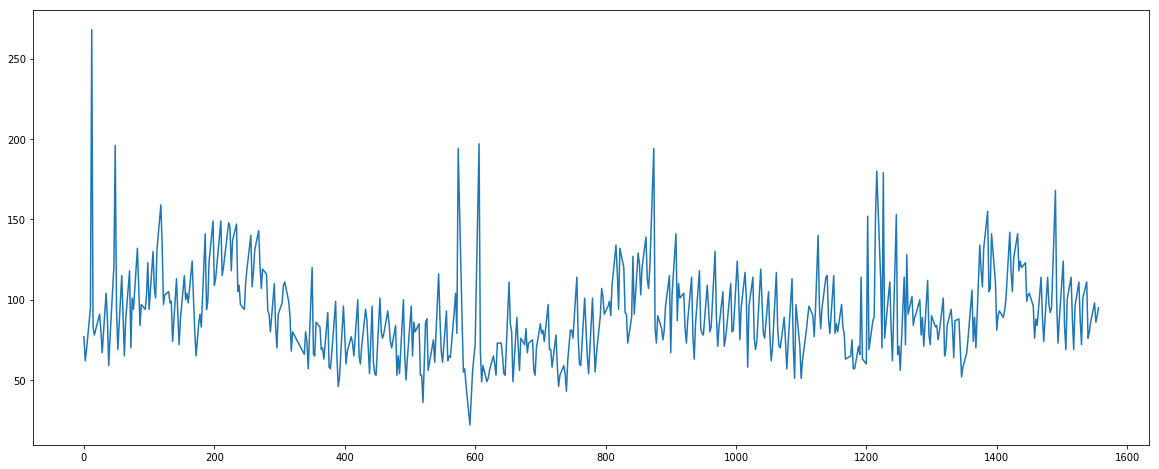

In [67]:
plt.figure(figsize=(20, 8))
plt.plot(df_crew[df_crew['crew'] == 'A']['absences_unplanned'])
plt.show()

In [68]:
df_crew[df_crew['crew'] == 'B']

,workdate,crew,absences_unplanned
3,2017-01-04,B,51
5,2017-01-05,B,60
6,2017-01-06,B,70
8,2017-01-07,B,64
15,2017-01-11,B,69
17,2017-01-12,B,74
18,2017-01-13,B,72
20,2017-01-14,B,61
27,2017-01-18,B,60
29,2017-01-19,B,52


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


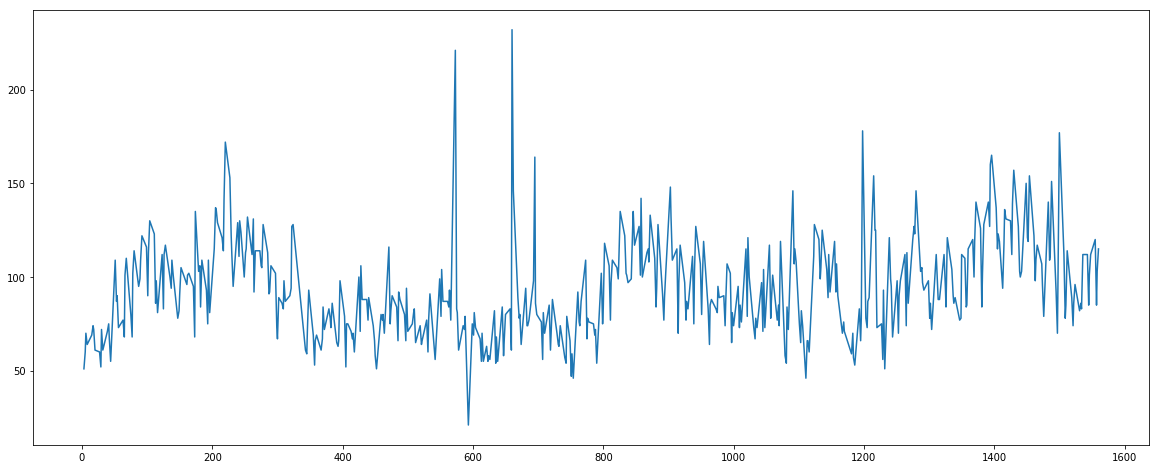

In [59]:
plt.figure(figsize=(20, 8))
plt.plot(df_crew[df_crew['crew'] == 'B']['absences_unplanned'])
plt.show()

In [64]:
df_crew[df_crew['crew'] == 'C']

,workdate,crew,absences_unplanned
1,2017-01-03,C,85
7,2017-01-06,C,82
9,2017-01-07,C,85
11,2017-01-09,C,113
13,2017-01-10,C,139
19,2017-01-13,C,97
21,2017-01-14,C,112
25,2017-01-17,C,97
31,2017-01-20,C,98
33,2017-01-21,C,110


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


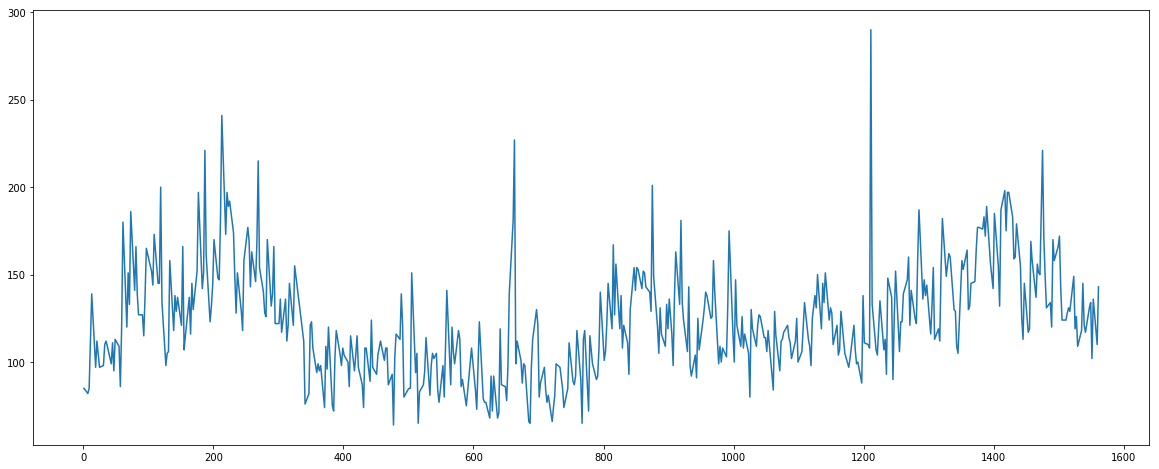

In [60]:
plt.figure(figsize=(20, 8))
plt.plot(df_crew[df_crew['crew'] == 'C']['absences_unplanned'])
plt.show()

#### Ensemble Testing

In [38]:
crew_maps = [jnap_crew_map['0'], jnap_crew_map['3'], jnap_crew_map['6']]
crew_maps

[['A', [0, 1, 2, 3]], ['B', [2, 3, 4, 5]], ['C', [4, 5, 0, 1]]]

In [39]:
all_predictions, crew_predictions = make_plant_predictions(plant_specs, crew_maps, df_model, df_base)

INFO:model:Plant Predictions
INFO:model:Crews: ['A', 'B', 'C']
INFO:model:Production Lines: ['Material', 'Body Shop', 'Paint Shop', 'Trim 1', 'Trim 2', 'Door Line', 'Engine Line', 'Chassis 1 & 2', 'Sunroof Deck', 'Chassis 3', 'Chassis 4', 'Final 1', 'Final 2', 'Rolls', 'Quality 1', 'Quality 2']
INFO:model:
Crew Dates: 
{'A': ['2019-09-02', '2019-09-03', '2019-09-04', '2019-09-05'], 'B': ['2019-09-04', '2019-09-05', '2019-09-06', '2019-09-07'], 'C': ['2019-09-02', '2019-09-03', '2019-09-06', '2019-09-07']}
INFO:model:Crew Level Model Table
INFO:model:Building Model Table
INFO:model:Retaining work days only
INFO:model:Defining CID-Level Features
INFO:model:Aggregating Frame
E:\anaconda3\lib\site-packages\pandas\core\groupby\generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)
INFO:model:Creating Calendrical Features
E:\Conway\HR-Analytics\source\model.py:566:


INFO:model:Crew Level Predictions
INFO:model:Crew A
INFO:model:Crew Rows: 517
INFO:model:Data Cutoff Date: 2019-08-19, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 8.269624
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 6.814357
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 2.977978
         Iterations: 2
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 2.850695
         Iterations: 2
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: 4.596769
         Iterations: 1
         Function evaluations: 112


INFO:model:Predictions : 517    103.949368
518     94.883771
519     87.209852
520     79.702098
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew B
INFO:model:Crew Rows: 527
INFO:model:Data Cutoff Date: 2019-08-21, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 8.590131
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 6.729646
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 2.780814
         Iterations: 2
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 2.699808
         Iterations: 2
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 4.532250
         Iterations: 1
         Function evaluations: 113


INFO:model:Predictions : 527    100.151692
528    100.262092
529    100.709812
530    101.430314
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew C
INFO:model:Crew Rows: 515
INFO:model:Data Cutoff Date: 2019-08-19, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 8.553119
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 6.948119
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 3.108428
         Iterations: 2
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: 3.055022
         Iterations: 2
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 4.670465
         Iterations: 1
         Function evaluations: 112


INFO:model:Predictions : 515    127.168902
516    125.357924
517    117.242097
518    114.710282
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Creating Prediction Frame
INFO:model:New Predictions Shape: (12, 8)
INFO:model:Production Line Level Predictions
INFO:model:SARIMAX Model
INFO:model:Crew A, Production Line: Material 
INFO:model:Rows: 516
INFO:model:Data Cutoff Date: 2019-08-19, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 5.829674
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 4.855700
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 0.821498
         Iterations: 2
         Function evaluations: 42
Optimization terminated successfully.
         Current function value: 0.595577
         Iterations: 2
         Function evaluations: 43
Optimization terminated successfully.
         Current function value: 2.546630
         Iterations: 5
         Function evaluations: 598


INFO:model:Predictions : 516    5.693389
517    5.073794
518    4.551029
519    4.062106
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew A, Production Line: Body Shop 
INFO:model:Rows: 517
INFO:model:Data Cutoff Date: 2019-08-19, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 5.798678
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 4.473575
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 0.423398
         Iterations: 2
         Function evaluations: 50
Optimization terminated successfully.
         Current function value: 0.169079
         Iterations: 3
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: 2.190693
         Iterations: 4
         Function evaluations: 479


INFO:model:Predictions : 517    5.042560
518    4.459812
519    4.045209
520    3.657290
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew A, Production Line: Paint Shop 
INFO:model:Rows: 517
INFO:model:Data Cutoff Date: 2019-08-19, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 6.016517
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 4.946840
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 0.945098
         Iterations: 2
         Function evaluations: 50
Optimization terminated successfully.
         Current function value: 0.675698
         Iterations: 2
         Function evaluations: 51
Optimization terminated successfully.
         Current function value: 2.623481
         Iterations: 1
         Function evaluations: 113


INFO:model:Predictions : 517    10.523281
518     9.339869
519     8.226232
520     7.106926
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew A, Production Line: Trim 1 
INFO:model:Rows: 516
INFO:model:Data Cutoff Date: 2019-08-19, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 5.935900
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 4.935514
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 0.991521
         Iterations: 2
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: 0.805302
         Iterations: 2
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: 2.666883
         Iterations: 1
         Function evaluations: 113


INFO:model:Predictions : 516    9.589144
517    8.952605
518    8.348468
519    7.755518
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew A, Production Line: Trim 2 
INFO:model:Rows: 515
INFO:model:Data Cutoff Date: 2019-08-19, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 5.301831
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 4.733993
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 0.849273
         Iterations: 2
         Function evaluations: 51
Optimization terminated successfully.
         Current function value: 0.563526
         Iterations: 2
         Function evaluations: 51
Optimization terminated successfully.
         Current function value: 2.476249
         Iterations: 1
         Function evaluations: 114


INFO:model:Predictions : 515    9.383021
516    8.652804
517    7.984333
518    7.330163
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew A, Production Line: Door Line 
INFO:model:Rows: 516
INFO:model:Data Cutoff Date: 2019-08-19, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 5.322594
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 4.539591
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 0.645171
         Iterations: 2
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: 0.345025
         Iterations: 2
         Function evaluations: 52
Optimization terminated successfully.
         Current function value: 2.272481
         Iterations: 1
         Function evaluations: 114


INFO:model:Predictions : 516    5.470169
517    4.752051
518    4.067291
519    3.382686
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew A, Production Line: Engine Line 
INFO:model:Rows: 516
INFO:model:Data Cutoff Date: 2019-08-19, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 5.487393
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 4.670864
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 0.770469
         Iterations: 2
         Function evaluations: 42
Optimization terminated successfully.
         Current function value: 0.610928
         Iterations: 2
         Function evaluations: 43
Optimization terminated successfully.
         Current function value: 2.447060
         Iterations: 5
         Function evaluations: 599


INFO:model:Predictions : 516    7.334092
517    6.064481
518    5.369377
519    4.812548
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew A, Production Line: Chassis 1 & 2 
INFO:model:Rows: 515
INFO:model:Data Cutoff Date: 2019-08-19, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 5.289890
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 4.671536
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 0.788669
         Iterations: 2
         Function evaluations: 52
Optimization terminated successfully.
         Current function value: 0.610471
         Iterations: 2
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 2.422891
         Iterations: 1
         Function evaluations: 114


INFO:model:Predictions : 515    8.072583
516    7.807652
517    7.479280
518    7.130613
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew A, Production Line: Sunroof Deck 
INFO:model:Rows: 515
INFO:model:Data Cutoff Date: 2019-08-19, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 4.555168
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 4.228787
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 0.328539
         Iterations: 2
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: 0.073502
         Iterations: 2
         Function evaluations: 42
Optimization terminated successfully.
         Current function value: 1.994784
         Iterations: 1
         Function evaluations: 114


INFO:model:Predictions : 515    3.619228
516    3.563366
517    3.470735
518    3.379809
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew A, Production Line: Chassis 3 
INFO:model:Rows: 515
INFO:model:Data Cutoff Date: 2019-08-19, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 5.434594
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 4.646621
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 0.721129
         Iterations: 2
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: 0.489828
         Iterations: 2
         Function evaluations: 45
Optimization terminated successfully.
         Current function value: 2.423380
         Iterations: 2
         Function evaluations: 239


INFO:model:Predictions : 515    6.752222
516    6.250743
517    5.710828
518    5.169113
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew A, Production Line: Chassis 4 
INFO:model:Rows: 515
INFO:model:Data Cutoff Date: 2019-08-19, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 5.132773
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 4.597650
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 0.672261
         Iterations: 2
         Function evaluations: 50
Optimization terminated successfully.
         Current function value: 0.492315
         Iterations: 3
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: 2.425158
         Iterations: 1
         Function evaluations: 118


INFO:model:Predictions : 515    6.354131
516    6.020991
517    5.596847
518    5.153631
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew A, Production Line: Final 1 
INFO:model:Rows: 515
INFO:model:Data Cutoff Date: 2019-08-19, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 5.093537
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 4.788599
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 0.770276
         Iterations: 2
         Function evaluations: 52
Optimization terminated successfully.
         Current function value: 0.533117
         Iterations: 3
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: 2.586579
         Iterations: 1
         Function evaluations: 114


INFO:model:Predictions : 515    9.555949
516    8.930217
517    8.345772
518    7.779315
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew A, Production Line: Final 2 
INFO:model:Rows: 515
INFO:model:Data Cutoff Date: 2019-08-19, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 4.870585
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 4.348384
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 0.510058
         Iterations: 2
         Function evaluations: 43
Optimization terminated successfully.
         Current function value: 0.293997
         Iterations: 2
         Function evaluations: 43
Optimization terminated successfully.
         Current function value: 2.098761
         Iterations: 3
         Function evaluations: 355


INFO:model:Predictions : 515    4.844250
516    4.237100
517    3.757074
518    3.296994
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew A, Production Line: Rolls 
INFO:model:Rows: 516
INFO:model:Data Cutoff Date: 2019-08-19, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 4.324753
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 3.883275
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 0.066549
         Iterations: 2
         Function evaluations: 45
Optimization terminated successfully.
         Current function value: -0.187041
         Iterations: 2
         Function evaluations: 43
Optimization terminated successfully.
         Current function value: 1.636706
         Iterations: 3
         Function evaluations: 357


INFO:model:Predictions : 516    1.599999
517    1.427040
518    1.177112
519    0.918440
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew A, Production Line: Quality 1 
INFO:model:Rows: 516
INFO:model:Data Cutoff Date: 2019-08-19, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 4.972650
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 4.303696
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 0.508325
         Iterations: 2
         Function evaluations: 43
Optimization terminated successfully.
         Current function value: 0.332298
         Iterations: 2
         Function evaluations: 52
Optimization terminated successfully.
         Current function value: 2.090354
         Iterations: 2
         Function evaluations: 237


INFO:model:Predictions : 516    5.084778
517    4.289682
518    3.687558
519    3.109239
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew A, Production Line: Quality 2 
INFO:model:Rows: 517
INFO:model:Data Cutoff Date: 2019-08-19, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 5.109433
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 4.253583
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 0.331896
         Iterations: 2
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: 0.032703
         Iterations: 3
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: 2.071292
         Iterations: 1
         Function evaluations: 115


INFO:model:Predictions : 517    4.290707
518    3.951991
519    3.646597
520    3.354061
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew B, Production Line: Material 
INFO:model:Rows: 527
INFO:model:Data Cutoff Date: 2019-08-21, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 6.292331
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 5.000942
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 0.977897
         Iterations: 3
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: 0.794331
         Iterations: 3
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: 2.754681
         Iterations: 1
         Function evaluations: 113


INFO:model:Predictions : 527    9.725490
528    9.710987
529    9.810878
530    9.882512
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew B, Production Line: Body Shop 
INFO:model:Rows: 527
INFO:model:Data Cutoff Date: 2019-08-21, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 6.217703
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 4.811435
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 0.633512
         Iterations: 2
         Function evaluations: 51
Optimization terminated successfully.
         Current function value: 0.369605
         Iterations: 3
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: 2.555491
         Iterations: 1
         Function evaluations: 114


INFO:model:Predictions : 527    4.927371
528    5.436981
529    5.732206
530    6.017722
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew B, Production Line: Paint Shop 
INFO:model:Rows: 527
INFO:model:Data Cutoff Date: 2019-08-21, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 6.324870
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 4.771113
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 0.707252
         Iterations: 2
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: 0.486115
         Iterations: 3
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 2.485459
         Iterations: 1
         Function evaluations: 114


INFO:model:Predictions : 527    9.045684
528    8.993851
529    8.969362
530    8.953177
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew B, Production Line: Trim 1 
INFO:model:Rows: 519
INFO:model:Data Cutoff Date: 2019-08-21, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 5.746759
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 4.857507
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 0.885844
         Iterations: 2
         Function evaluations: 52
Optimization terminated successfully.
         Current function value: 0.620701
         Iterations: 2
         Function evaluations: 51
Optimization terminated successfully.
         Current function value: 2.650557
         Iterations: 1
         Function evaluations: 114


INFO:model:Predictions : 519    10.891056
520    11.090509
521    11.306288
522    11.527884
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew B, Production Line: Trim 2 
INFO:model:Rows: 520
INFO:model:Data Cutoff Date: 2019-08-21, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 5.461530
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 4.494853
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 0.501820
         Iterations: 2
         Function evaluations: 43
Optimization terminated successfully.
         Current function value: 0.301148
         Iterations: 2
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: 2.280420
         Iterations: 1
         Function evaluations: 114


INFO:model:Predictions : 520    5.251545
521    5.247384
522    5.267309
523    5.294714
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew B, Production Line: Door Line 
INFO:model:Rows: 519
INFO:model:Data Cutoff Date: 2019-08-21, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 5.247837
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 4.636269
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 0.750804
         Iterations: 2
         Function evaluations: 50
Optimization terminated successfully.
         Current function value: 0.368099
         Iterations: 3
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: 2.420410
         Iterations: 1
         Function evaluations: 114


INFO:model:Predictions : 519    6.582253
520    6.695397
521    6.818847
522    6.970931
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew B, Production Line: Engine Line 
INFO:model:Rows: 519
INFO:model:Data Cutoff Date: 2019-08-21, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 5.286008
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 4.605651
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 0.674171
         Iterations: 2
         Function evaluations: 52
Optimization terminated successfully.
         Current function value: 0.477298
         Iterations: 3
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: 2.447064
         Iterations: 1
         Function evaluations: 114


INFO:model:Predictions : 519    8.243499
520    8.235063
521    8.218266
522    8.205804
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew B, Production Line: Chassis 1 & 2 
INFO:model:Rows: 523
INFO:model:Data Cutoff Date: 2019-08-21, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 5.717911
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 4.663313
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 0.720572
         Iterations: 2
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: 0.379576
         Iterations: 3
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: 2.446511
         Iterations: 1
         Function evaluations: 137


INFO:model:Predictions : 523    6.799018
524    7.151137
525    7.540928
526    7.947440
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew B, Production Line: Sunroof Deck 
INFO:model:Rows: 521
INFO:model:Data Cutoff Date: 2019-08-21, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 4.865691
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 4.091454
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 0.162591
         Iterations: 2
         Function evaluations: 50
Optimization terminated successfully.
         Current function value: -0.175858
         Iterations: 3
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: 1.910216
         Iterations: 1
         Function evaluations: 114


INFO:model:Predictions : 521    3.381352
522    3.303313
523    3.291089
524    3.284165
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew B, Production Line: Chassis 3 
INFO:model:Rows: 526
INFO:model:Data Cutoff Date: 2019-08-21, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 5.893996
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 4.663666
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 0.717988
         Iterations: 2
         Function evaluations: 52
Optimization terminated successfully.
         Current function value: 0.482808
         Iterations: 3
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: 2.442608
         Iterations: 1
         Function evaluations: 116


INFO:model:Predictions : 526    6.184594
527    6.462640
528    6.700186
529    6.923706
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew B, Production Line: Chassis 4 
INFO:model:Rows: 518
INFO:model:Data Cutoff Date: 2019-08-21, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 4.891106
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 4.373763
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 0.440294
         Iterations: 2
         Function evaluations: 50
Optimization terminated successfully.
         Current function value: 0.144720
         Iterations: 3
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: 2.135706
         Iterations: 1
         Function evaluations: 114


INFO:model:Predictions : 518    4.318368
519    4.140779
520    3.952087
521    3.760363
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew B, Production Line: Final 1 
INFO:model:Rows: 522
INFO:model:Data Cutoff Date: 2019-08-21, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 5.382283
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 4.565698
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 0.609879
         Iterations: 2
         Function evaluations: 52
Optimization terminated successfully.
         Current function value: 0.402347
         Iterations: 3
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: 2.337913
         Iterations: 1
         Function evaluations: 114


INFO:model:Predictions : 522    8.743422
523    8.380679
524    8.111545
525    7.861870
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew B, Production Line: Final 2 
INFO:model:Rows: 522
INFO:model:Data Cutoff Date: 2019-08-21, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 4.993095
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 4.237392
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 0.262260
         Iterations: 2
         Function evaluations: 42
Optimization terminated successfully.
         Current function value: 0.062373
         Iterations: 3
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: 2.003439
         Iterations: 1
         Function evaluations: 114


INFO:model:Predictions : 522    4.297413
523    4.388359
524    4.471392
525    4.557961
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew B, Production Line: Rolls 
INFO:model:Rows: 525
INFO:model:Data Cutoff Date: 2019-08-21, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 4.714965
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 3.858835
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 0.115686
         Iterations: 2
         Function evaluations: 45
Optimization terminated successfully.
         Current function value: -0.067506
         Iterations: 2
         Function evaluations: 45
Optimization terminated successfully.
         Current function value: 1.630231
         Iterations: 1
         Function evaluations: 115


INFO:model:Predictions : 525    1.913439
526    2.006320
527    2.091213
528    2.173125
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew B, Production Line: Quality 1 
INFO:model:Rows: 526
INFO:model:Data Cutoff Date: 2019-08-21, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 5.516326
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 4.190622
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 0.394032
         Iterations: 2
         Function evaluations: 45
Optimization terminated successfully.
         Current function value: 0.111961
         Iterations: 3
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: 2.043253
         Iterations: 2
         Function evaluations: 239


INFO:model:Predictions : 526    3.757790
527    3.435785
528    3.260143
529    3.105096
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew B, Production Line: Quality 2 
INFO:model:Rows: 518
INFO:model:Data Cutoff Date: 2019-08-21, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 4.758431
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 4.195569
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 0.361469
         Iterations: 2
         Function evaluations: 43
Optimization terminated successfully.
         Current function value: -0.018169
         Iterations: 3
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: 1.944462
         Iterations: 1
         Function evaluations: 115


INFO:model:Predictions : 518    3.713516
519    3.471999
520    3.352260
521    3.273159
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew C, Production Line: Material 
INFO:model:Rows: 514
INFO:model:Data Cutoff Date: 2019-08-19, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 6.252997
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 5.050140
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 1.198875
         Iterations: 2
         Function evaluations: 50
Optimization terminated successfully.
         Current function value: 1.011482
         Iterations: 3
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: 2.825686
         Iterations: 1
         Function evaluations: 113


INFO:model:Predictions : 514    11.658880
515    11.900996
516    12.019102
517    12.061371
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew C, Production Line: Body Shop 
INFO:model:Rows: 515
INFO:model:Data Cutoff Date: 2019-08-19, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 6.098011
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 4.790212
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 0.884739
         Iterations: 2
         Function evaluations: 43
Optimization terminated successfully.
         Current function value: 0.627363
         Iterations: 2
         Function evaluations: 42
Optimization terminated successfully.
         Current function value: 2.494085
         Iterations: 1
         Function evaluations: 114


INFO:model:Predictions : 515    8.800658
516    8.824343
517    7.973207
518    7.706573
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew C, Production Line: Paint Shop 
INFO:model:Rows: 515
INFO:model:Data Cutoff Date: 2019-08-19, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 6.268359
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 5.161577
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 1.206174
         Iterations: 2
         Function evaluations: 52
Optimization terminated successfully.
         Current function value: 1.031317
         Iterations: 3
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: 2.836675
         Iterations: 1
         Function evaluations: 113


INFO:model:Predictions : 515    14.675130
516    14.380711
517    12.751661
518    12.203120
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew C, Production Line: Trim 1 
INFO:model:Rows: 512
INFO:model:Data Cutoff Date: 2019-08-19, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 6.129702
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 5.125174
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 1.123461
         Iterations: 2
         Function evaluations: 52
Optimization terminated successfully.
         Current function value: 0.890725
         Iterations: 2
         Function evaluations: 52
Optimization terminated successfully.
         Current function value: 2.830899
         Iterations: 1
         Function evaluations: 113


INFO:model:Predictions : 512    12.694019
513    12.514443
514    11.887872
515    11.673065
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew C, Production Line: Trim 2 
INFO:model:Rows: 506
INFO:model:Data Cutoff Date: 2019-08-19, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 4.700037
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 4.711344
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 0.701287
         Iterations: 2
         Function evaluations: 52
Optimization terminated successfully.
         Current function value: 0.443666
         Iterations: 3
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: 2.599173
         Iterations: 1
         Function evaluations: 114


INFO:model:Predictions : 506    7.968128
507    7.913998
508    7.516852
509    7.374378
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew C, Production Line: Door Line 
INFO:model:Rows: 510
INFO:model:Data Cutoff Date: 2019-08-19, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 5.223759
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 4.783392
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 0.828061
         Iterations: 2
         Function evaluations: 51
Optimization terminated successfully.
         Current function value: 0.678170
         Iterations: 2
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 2.641180
         Iterations: 1
         Function evaluations: 113


INFO:model:Predictions : 510    7.390427
511    7.336283
512    7.169311
513    7.116462
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew C, Production Line: Engine Line 
INFO:model:Rows: 507
INFO:model:Data Cutoff Date: 2019-08-19, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 5.139999
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 4.819737
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 0.690302
         Iterations: 3
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: 0.567921
         Iterations: 3
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: 2.494333
         Iterations: 1
         Function evaluations: 114


INFO:model:Predictions : 507    11.114577
508    10.599498
509     9.097807
510     8.589561
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew C, Production Line: Chassis 1 & 2 
INFO:model:Rows: 510
INFO:model:Data Cutoff Date: 2019-08-19, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 5.434505
         Iterations: 1
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 4.873114
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 0.988279
         Iterations: 2
         Function evaluations: 51
Optimization terminated successfully.
         Current function value: 0.809259
         Iterations: 3
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: 2.652375
         Iterations: 1
         Function evaluations: 114


INFO:model:Predictions : 510    8.325523
511    8.470500
512    8.520386
513    8.555363
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew C, Production Line: Sunroof Deck 
INFO:model:Rows: 510
INFO:model:Data Cutoff Date: 2019-08-19, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 4.641581
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 4.338023
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 0.376748
         Iterations: 2
         Function evaluations: 51
Optimization terminated successfully.
         Current function value: 0.087508
         Iterations: 3
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: 2.146409
         Iterations: 1
         Function evaluations: 114


INFO:model:Predictions : 510    4.928717
511    4.840025
512    4.502880
513    4.382677
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew C, Production Line: Chassis 3 
INFO:model:Rows: 510
INFO:model:Data Cutoff Date: 2019-08-19, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 5.386309
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 4.754494
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 0.840604
         Iterations: 2
         Function evaluations: 50
Optimization terminated successfully.
         Current function value: 0.652153
         Iterations: 2
         Function evaluations: 51
Optimization terminated successfully.
         Current function value: 2.506322
         Iterations: 1
         Function evaluations: 114


INFO:model:Predictions : 510    8.914293
511    8.343410
512    7.728134
513    7.517583
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew C, Production Line: Chassis 4 
INFO:model:Rows: 511
INFO:model:Data Cutoff Date: 2019-08-19, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 5.346189
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 4.640085
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 0.771812
         Iterations: 2
         Function evaluations: 51
Optimization terminated successfully.
         Current function value: 0.581291
         Iterations: 3
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: 2.387007
         Iterations: 1
         Function evaluations: 114


INFO:model:Predictions : 511    6.435057
512    6.231300
513    6.205165
514    6.200489
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew C, Production Line: Final 1 
INFO:model:Rows: 513
INFO:model:Data Cutoff Date: 2019-08-19, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 5.566204
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 4.701158
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 0.809724
         Iterations: 2
         Function evaluations: 50
Optimization terminated successfully.
         Current function value: 0.561363
         Iterations: 3
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: 2.462198
         Iterations: 1
         Function evaluations: 114


INFO:model:Predictions : 513    8.104502
514    8.079188
515    7.856661
516    7.786838
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew C, Production Line: Final 2 
INFO:model:Rows: 508
INFO:model:Data Cutoff Date: 2019-08-19, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 4.934495
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 4.531762
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 0.657302
         Iterations: 2
         Function evaluations: 43
Optimization terminated successfully.
         Current function value: 0.447002
         Iterations: 2
         Function evaluations: 51
Optimization terminated successfully.
         Current function value: 2.261987
         Iterations: 1
         Function evaluations: 114


INFO:model:Predictions : 508    5.550521
509    5.372814
510    4.864697
511    4.693962
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew C, Production Line: Rolls 
INFO:model:Rows: 513
INFO:model:Data Cutoff Date: 2019-08-19, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 4.494043
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 3.973478
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 0.172511
         Iterations: 2
         Function evaluations: 42
Optimization terminated successfully.
         Current function value: -0.011858
         Iterations: 3
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: 1.776892
         Iterations: 1
         Function evaluations: 115


INFO:model:Predictions : 513    3.567059
514    3.344094
515    2.862169
516    2.703005
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew C, Production Line: Quality 1 
INFO:model:Rows: 515
INFO:model:Data Cutoff Date: 2019-08-19, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 5.551178
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 4.437925
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 0.398364
         Iterations: 2
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: 0.032880
         Iterations: 3
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 2.189443
         Iterations: 1
         Function evaluations: 114


INFO:model:Predictions : 515    5.437383
516    5.284578
517    5.220095
518    5.190669
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Crew C, Production Line: Quality 2 
INFO:model:Rows: 507
INFO:model:Data Cutoff Date: 2019-08-19, Prediction Date: 2019-09-01
INFO:model:Future Prediction


Optimization terminated successfully.
         Current function value: 4.812143
         Iterations: 1
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 4.451838
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 0.424331
         Iterations: 2
         Function evaluations: 50
Optimization terminated successfully.
         Current function value: 0.145236
         Iterations: 3
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: 2.127937
         Iterations: 1
         Function evaluations: 114


INFO:model:Predictions : 507    5.672008
508    5.404605
509    4.642368
510    4.387343
dtype: float64
INFO:model:Actuals     : [0, 0, 0, 0]
INFO:model:Creating Prediction Frame
INFO:model:New Predictions Shape: (192, 9)
INFO:model:Ensemble Model
INFO:model:Single Model


In [40]:
all_predictions

,crew,production_line,workdate,predicted,model_feature1,model_feature2,model_feature3,model_feature4,model_feature5
0,A,Material,2019-09-02,6,absences_unplanned_rolling_median_12,day_of_week,week,lost_hours,actual_hours
1,A,Material,2019-09-03,6,absences_unplanned_rolling_median_12,day_of_week,week,lost_hours,actual_hours
2,A,Material,2019-09-04,5,absences_unplanned_rolling_median_12,day_of_week,week,lost_hours,actual_hours
3,A,Material,2019-09-05,5,absences_unplanned_rolling_median_12,day_of_week,week,lost_hours,actual_hours
4,A,Body Shop,2019-09-02,6,month,day_of_week,actual_hours,absences_unplanned_rolling_median_12,day
5,A,Body Shop,2019-09-03,5,month,day_of_week,actual_hours,absences_unplanned_rolling_median_12,day
6,A,Body Shop,2019-09-04,5,month,day_of_week,actual_hours,absences_unplanned_rolling_median_12,day
7,A,Body Shop,2019-09-05,4,month,day_of_week,actual_hours,absences_unplanned_rolling_median_12,day
8,A,Paint Shop,2019-09-02,11,day_of_week,month,day,actual_hours,lost_hours
9,A,Paint Shop,2019-09-03,10,day_of_week,month,day,actual_hours,lost_hours


In [41]:
crew_predictions.shape

(12, 8)

In [42]:
crew_predictions

,crew,workdate,predicted,model_feature1,model_feature2,model_feature3,model_feature4,model_feature5
0,A,2019-09-02,104,actual_hours,absences_unplanned_rolling_median_12,day_of_week,month,lost_hours
1,A,2019-09-03,95,actual_hours,absences_unplanned_rolling_median_12,day_of_week,month,lost_hours
2,A,2019-09-04,88,actual_hours,absences_unplanned_rolling_median_12,day_of_week,month,lost_hours
3,A,2019-09-05,80,actual_hours,absences_unplanned_rolling_median_12,day_of_week,month,lost_hours
4,B,2019-09-04,101,lost_hours,actual_hours,absences_unplanned_rolling_median_12,day_of_week,day_of_year
5,B,2019-09-05,101,lost_hours,actual_hours,absences_unplanned_rolling_median_12,day_of_week,day_of_year
6,B,2019-09-06,101,lost_hours,actual_hours,absences_unplanned_rolling_median_12,day_of_week,day_of_year
7,B,2019-09-07,102,lost_hours,actual_hours,absences_unplanned_rolling_median_12,day_of_week,day_of_year
8,C,2019-09-02,128,lost_hours,actual_hours,month,absences_unplanned_rolling_median_12,day
9,C,2019-09-03,126,lost_hours,actual_hours,month,absences_unplanned_rolling_median_12,day


In [ ]:
make_share_predictions(4, pd.to_datetime(prediction_date), df_model, 'absences_unplanned', crew_predictions, plant_specs['model']['levels'])

In [ ]:
plines = list(plant_specs['model']['production_lines'].keys())
plines

In [ ]:
all_predictions = all_predictions[all_predictions['production_line'].isin(plines)]

In [ ]:
all_predictions

### End of Notebook